In [194]:
import tensorflow as tf
import cv2
import scipy
import pickle
import time
from scipy import fftpack as scifft
from PIL import Image
import numpy as np
#import platform
#import tempfile
import os
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import ndimage as ndi
from skimage import io as skio



def idct2_blocks(X):
    O=scifft.idct(X,type=2,axis=0,norm='ortho')
    O=scifft.idct(O,type=2,axis=1,norm='ortho')
    return O
def dct2_blocks(X):
    O=scifft.dct(X,type=2,axis=0,norm='ortho')
    O=scifft.dct(O,type=2,axis=1,norm='ortho')
    return O

class DCT_denoiser():
    def __init__(self,N=7): # N doit etre impaire
        self.N=N
        # calcul des poids de ce reseau
        A=np.zeros((N,N,N**2))
        
        for k in range(N):
            for m in range(N):
                A[k,m,k+m*N]=1.0
        D=idct2_blocks(A)
        iD=np.fliplr(np.flipud(D))
        
        self.seuil=tf.placeholder(tf.float32,shape=())
        self.x=tf.placeholder(tf.float32,[None,None,None,1])
        tr1=tf.nn.conv2d(self.x,D.reshape((N,N,1,N*N)),strides=[1,1,1,1],padding='VALID')    
        cond=tf.less(tf.abs(tr1),self.seuil)
        tr1=tf.where(cond,tf.zeros(tf.shape(tr1)),tr1)
        tr1p=tf.pad(tr1,[[0,0], [N//2,N//2], [N//2,N//2] ,[0,0]],'CONSTANT')
        self.out=tf.nn.conv2d(tr1p,iD.reshape((N,N,N*N,1)),strides=[1,1,1,1],padding='SAME')

    def do_denoise(self,im,s,sess):   
        out=sess.run([self.out],feed_dict={self.x:im.reshape((1,*im.shape,1)),self.seuil:s })        
        return out[0].reshape(im.shape)   
    def get_mask(self,sh): # renvoie le mask par lequel diviser la sortie pour obtenir la vraie restauration
        N=self.N
        sigy=np.concatenate((np.arange(1,N),N*np.ones((sh[0]-2*N+2,)),np.arange(N-1,0,-1))).reshape((sh[0],1))
        sigx= np.concatenate((np.arange(1,N),N*np.ones((sh[1]-2*N+2,)),np.arange(N-1,0,-1))).reshape((1,sh[1]))
        return sigx*sigy

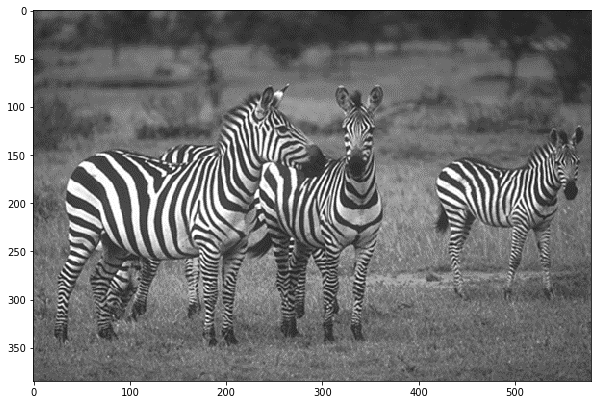

In [195]:
datadir='./data/'
im=np.float32(skio.imread(datadir+'/images_test/zebres.png'))
if len(im.shape)>2: # image couleur
    im=im.sum(axis=2)/3
plt.figure(figsize=(10,10))
plt.imshow(im, cmap='gray')

In [196]:
sess=tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [197]:
denoiser_dct=DCT_denoiser()
sigma=25
imb=im+sigma*np.random.randn(*im.shape) #version bruitee
out=denoiser_dct.do_denoise(imb,3*sigma,sess)
#mask=denoiser_dct.get_mask(im.shape) # ce mask ne depend que de la taille de l'image
#out=out/mask

InvalidArgumentError: You must feed a value for placeholder tensor 'Placeholder_43' with dtype float and shape [?,?,?,1]
	 [[node Placeholder_43 (defined at <ipython-input-194-20519a1aa9fc>:41)  = Placeholder[dtype=DT_FLOAT, shape=[?,?,?,1], _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op 'Placeholder_43', defined at:
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tornado/ioloop.py", line 832, in start
    self._run_callback(self._callbacks.popleft())
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tornado/ioloop.py", line 605, in _run_callback
    ret = callback()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 536, in <lambda>
    self.io_loop.add_callback(lambda : self._handle_events(self.socket, 0))
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2802, in run_ast_nodes
    if self.run_code(code, result):
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-197-de95d79305b2>", line 1, in <module>
    denoiser_dct=DCT_denoiser()
  File "<ipython-input-194-20519a1aa9fc>", line 41, in __init__
    self.x=tf.placeholder(tf.float32,[None,None,None,1])
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/ops/array_ops.py", line 1747, in placeholder
    return gen_array_ops.placeholder(dtype=dtype, shape=shape, name=name)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 5206, in placeholder
    "Placeholder", dtype=dtype, shape=shape, name=name)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 488, in new_func
    return func(*args, **kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3274, in create_op
    op_def=op_def)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1770, in __init__
    self._traceback = tf_stack.extract_stack()

InvalidArgumentError (see above for traceback): You must feed a value for placeholder tensor 'Placeholder_43' with dtype float and shape [?,?,?,1]
	 [[node Placeholder_43 (defined at <ipython-input-194-20519a1aa9fc>:41)  = Placeholder[dtype=DT_FLOAT, shape=[?,?,?,1], _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]


In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(imb, cmap='gray')

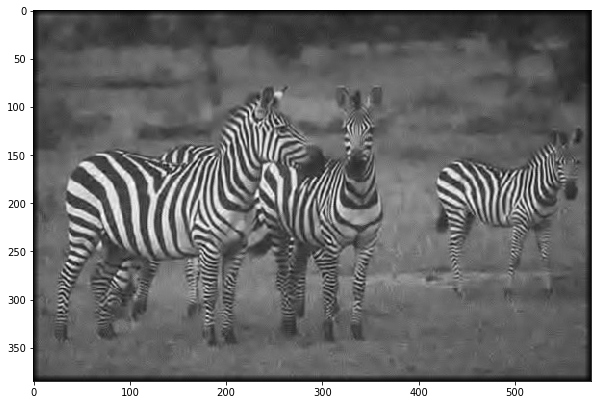

In [198]:
plt.figure(figsize=(10,10))
plt.imshow(out, cmap='gray')

In [168]:
out.shape

(385, 580)

In [7]:
from scipy.fftpack import idct, idctn, dct, dctn
N=7
A=np.zeros((N,N,N**2))  
for k in range(N):
	for m in range(N):
		A[k,m,k+m*N]=1.0

O=idct(A,type=2,axis=0,norm='ortho')
D=idct(O,type=2,axis=1,norm='ortho')
DD = D.reshape((N,N,1,N*N))

In [8]:
DD[0,0,0]

array([0.14285714, 0.19696518, 0.1820232 , 0.15795381, 0.12596396,
       0.08765775, 0.04495602, 0.19696518, 0.27156698, 0.25096563,
       0.21777981, 0.1736736 , 0.12085868, 0.06198339, 0.1820232 ,
       0.25096563, 0.23192711, 0.20125881, 0.16049854, 0.11169021,
       0.05728127, 0.15795381, 0.21777981, 0.20125881, 0.17464585,
       0.13927542, 0.09692113, 0.04970682, 0.12596396, 0.1736736 ,
       0.16049854, 0.13927542, 0.11106844, 0.07729202, 0.03963987,
       0.08765775, 0.12085868, 0.11169021, 0.09692113, 0.07729202,
       0.05378717, 0.0275852 , 0.04495602, 0.06198339, 0.05728127,
       0.04970682, 0.03963987, 0.0275852 , 0.0141473 ])

In [25]:
test = dctn(imb, type=2, norm='ortho')
test2 = (abs(test) > 80)*test
test3 = idctn(test2, type=2, norm='ortho')

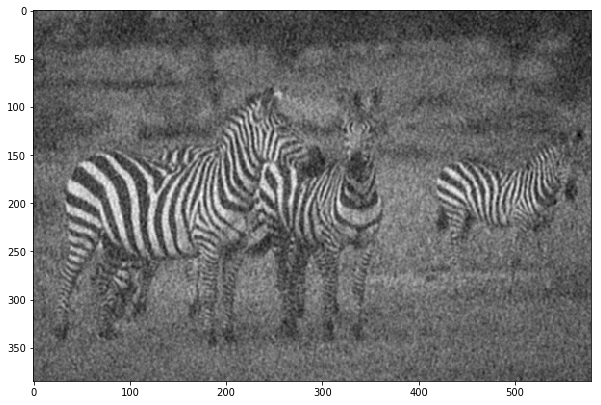

In [26]:
plt.figure(figsize=(10,10))
plt.imshow(test3, cmap='gray')
plt.show()

In [13]:
(abs(test) > 10)*test

array([[ 5.31547884e+04,  1.53240504e+03, -2.29312112e+03, ...,
        -6.16134338e+01, -1.25150391e+01,  1.74328801e+01],
       [-3.82459860e+03,  7.39839781e+02, -7.36942346e+02, ...,
        -0.00000000e+00,  2.75156173e+01, -2.40243542e+01],
       [-6.68446452e+03, -1.08190852e+02, -6.47330412e+01, ...,
         1.23841846e+01, -5.08516459e+01,  1.12773634e+01],
       ...,
       [ 2.93990471e+01, -0.00000000e+00,  1.21840945e+01, ...,
         1.12496486e+01, -3.40248455e+01, -0.00000000e+00],
       [ 3.87734791e+01,  0.00000000e+00,  2.23420094e+01, ...,
        -0.00000000e+00,  0.00000000e+00,  1.82926112e+01],
       [-0.00000000e+00,  6.68034167e+01,  0.00000000e+00, ...,
        -6.67152421e+01, -3.46837008e+01,  5.92228984e+01]])

In [43]:
D[:,:,2]

array([[ 0.1820232 ,  0.1820232 ,  0.1820232 ,  0.1820232 ,  0.1820232 ,
         0.1820232 ,  0.1820232 ],
       [ 0.04495602,  0.04495602,  0.04495602,  0.04495602,  0.04495602,
         0.04495602,  0.04495602],
       [-0.12596396, -0.12596396, -0.12596396, -0.12596396, -0.12596396,
        -0.12596396, -0.12596396],
       [-0.20203051, -0.20203051, -0.20203051, -0.20203051, -0.20203051,
        -0.20203051, -0.20203051],
       [-0.12596396, -0.12596396, -0.12596396, -0.12596396, -0.12596396,
        -0.12596396, -0.12596396],
       [ 0.04495602,  0.04495602,  0.04495602,  0.04495602,  0.04495602,
         0.04495602,  0.04495602],
       [ 0.1820232 ,  0.1820232 ,  0.1820232 ,  0.1820232 ,  0.1820232 ,
         0.1820232 ,  0.1820232 ]])

In [42]:
idctn(A[0,2].reshape(7,7), type=2, norm='ortho')

array([[ 0.1820232 ,  0.1820232 ,  0.1820232 ,  0.1820232 ,  0.1820232 ,
         0.1820232 ,  0.1820232 ],
       [ 0.04495602,  0.04495602,  0.04495602,  0.04495602,  0.04495602,
         0.04495602,  0.04495602],
       [-0.12596396, -0.12596396, -0.12596396, -0.12596396, -0.12596396,
        -0.12596396, -0.12596396],
       [-0.20203051, -0.20203051, -0.20203051, -0.20203051, -0.20203051,
        -0.20203051, -0.20203051],
       [-0.12596396, -0.12596396, -0.12596396, -0.12596396, -0.12596396,
        -0.12596396, -0.12596396],
       [ 0.04495602,  0.04495602,  0.04495602,  0.04495602,  0.04495602,
         0.04495602,  0.04495602],
       [ 0.1820232 ,  0.1820232 ,  0.1820232 ,  0.1820232 ,  0.1820232 ,
         0.1820232 ,  0.1820232 ]])

In [44]:
A[0,2]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [71]:
iD=np.fliplr(np.flipud(D))
test = iD.reshape((N,N,N*N,1))

In [75]:
test[:,:,2,0]

array([[ 0.1820232 ,  0.1820232 ,  0.1820232 ,  0.1820232 ,  0.1820232 ,
         0.1820232 ,  0.1820232 ],
       [ 0.04495602,  0.04495602,  0.04495602,  0.04495602,  0.04495602,
         0.04495602,  0.04495602],
       [-0.12596396, -0.12596396, -0.12596396, -0.12596396, -0.12596396,
        -0.12596396, -0.12596396],
       [-0.20203051, -0.20203051, -0.20203051, -0.20203051, -0.20203051,
        -0.20203051, -0.20203051],
       [-0.12596396, -0.12596396, -0.12596396, -0.12596396, -0.12596396,
        -0.12596396, -0.12596396],
       [ 0.04495602,  0.04495602,  0.04495602,  0.04495602,  0.04495602,
         0.04495602,  0.04495602],
       [ 0.1820232 ,  0.1820232 ,  0.1820232 ,  0.1820232 ,  0.1820232 ,
         0.1820232 ,  0.1820232 ]])

In [76]:
test2 = D.reshape((N,N,N*N,1))

In [89]:
np.array_equal(np.round(test[:,:,2,0], 4), np.round(D[:,:,2],4))

True

In [84]:
D[:,:,2]

array([[ 0.1820232 ,  0.1820232 ,  0.1820232 ,  0.1820232 ,  0.1820232 ,
         0.1820232 ,  0.1820232 ],
       [ 0.04495602,  0.04495602,  0.04495602,  0.04495602,  0.04495602,
         0.04495602,  0.04495602],
       [-0.12596396, -0.12596396, -0.12596396, -0.12596396, -0.12596396,
        -0.12596396, -0.12596396],
       [-0.20203051, -0.20203051, -0.20203051, -0.20203051, -0.20203051,
        -0.20203051, -0.20203051],
       [-0.12596396, -0.12596396, -0.12596396, -0.12596396, -0.12596396,
        -0.12596396, -0.12596396],
       [ 0.04495602,  0.04495602,  0.04495602,  0.04495602,  0.04495602,
         0.04495602,  0.04495602],
       [ 0.1820232 ,  0.1820232 ,  0.1820232 ,  0.1820232 ,  0.1820232 ,
         0.1820232 ,  0.1820232 ]])

In [90]:
np.array_equal(D,iD)

False

In [106]:
for i in range(49):
    if not np.array_equal(np.round(D[:,:,i],4),np.round(iD[:,:,i],4)):
        print(i)

1
3
5
7
9
11
13
15
17
19
21
23
25
27
29
31
33
35
37
39
41
43
45
47


In [201]:
D[:,:,3]

array([[ 1.57953812e-01,  1.57953812e-01,  1.57953812e-01,
         1.57953812e-01,  1.57953812e-01,  1.57953812e-01,
         1.57953812e-01],
       [-8.76577526e-02, -8.76577526e-02, -8.76577526e-02,
        -8.76577526e-02, -8.76577526e-02, -8.76577526e-02,
        -8.76577526e-02],
       [-1.96965182e-01, -1.96965182e-01, -1.96965182e-01,
        -1.96965182e-01, -1.96965182e-01, -1.96965182e-01,
        -1.96965182e-01],
       [-1.67849944e-16, -1.67849944e-16, -1.67849944e-16,
        -1.67849944e-16, -1.67849944e-16, -1.67849944e-16,
        -1.67849944e-16],
       [ 1.96965182e-01,  1.96965182e-01,  1.96965182e-01,
         1.96965182e-01,  1.96965182e-01,  1.96965182e-01,
         1.96965182e-01],
       [ 8.76577526e-02,  8.76577526e-02,  8.76577526e-02,
         8.76577526e-02,  8.76577526e-02,  8.76577526e-02,
         8.76577526e-02],
       [-1.57953812e-01, -1.57953812e-01, -1.57953812e-01,
        -1.57953812e-01, -1.57953812e-01, -1.57953812e-01,
        -1.5795381

In [203]:
iD[:,:,3]

array([[-1.57953812e-01, -1.57953812e-01, -1.57953812e-01,
        -1.57953812e-01, -1.57953812e-01, -1.57953812e-01,
        -1.57953812e-01],
       [ 8.76577526e-02,  8.76577526e-02,  8.76577526e-02,
         8.76577526e-02,  8.76577526e-02,  8.76577526e-02,
         8.76577526e-02],
       [ 1.96965182e-01,  1.96965182e-01,  1.96965182e-01,
         1.96965182e-01,  1.96965182e-01,  1.96965182e-01,
         1.96965182e-01],
       [-1.67849944e-16, -1.67849944e-16, -1.67849944e-16,
        -1.67849944e-16, -1.67849944e-16, -1.67849944e-16,
        -1.67849944e-16],
       [-1.96965182e-01, -1.96965182e-01, -1.96965182e-01,
        -1.96965182e-01, -1.96965182e-01, -1.96965182e-01,
        -1.96965182e-01],
       [-8.76577526e-02, -8.76577526e-02, -8.76577526e-02,
        -8.76577526e-02, -8.76577526e-02, -8.76577526e-02,
        -8.76577526e-02],
       [ 1.57953812e-01,  1.57953812e-01,  1.57953812e-01,
         1.57953812e-01,  1.57953812e-01,  1.57953812e-01,
         1.5795381

In [103]:
D[:,:,2][0,0]

0.18202319889479066

In [104]:
iD[:,:,2][0,0]

0.18202319889479054

In [169]:
D.shape

(7, 7, 49)